<a href="https://colab.research.google.com/github/endii17/Python_Fraud_Transaction_Prediction/blob/main/Final_project_souce_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_excel('churn_prediction.xlsx')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

In [ ]:
df.head(1)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


### **1. Data Preprocessing:**

In [ ]:
# Change all column names to lowercase for easy to mention:
df.columns = df.columns.str.lower()

In [ ]:
# Check imbalance data:
imb_df = df.groupby('churn')['customerid'].count().reset_index()
imb_df['%'] = imb_df['customerid']/sum(imb_df['customerid'])
imb_df

,churn,customerid,%
0,0,4682,0.831616
1,1,948,0.168384


&rarr; Data is not much imbalanced &rarr; Acceptable

#### **1.1 Missing values:**

<AxesSubplot:>

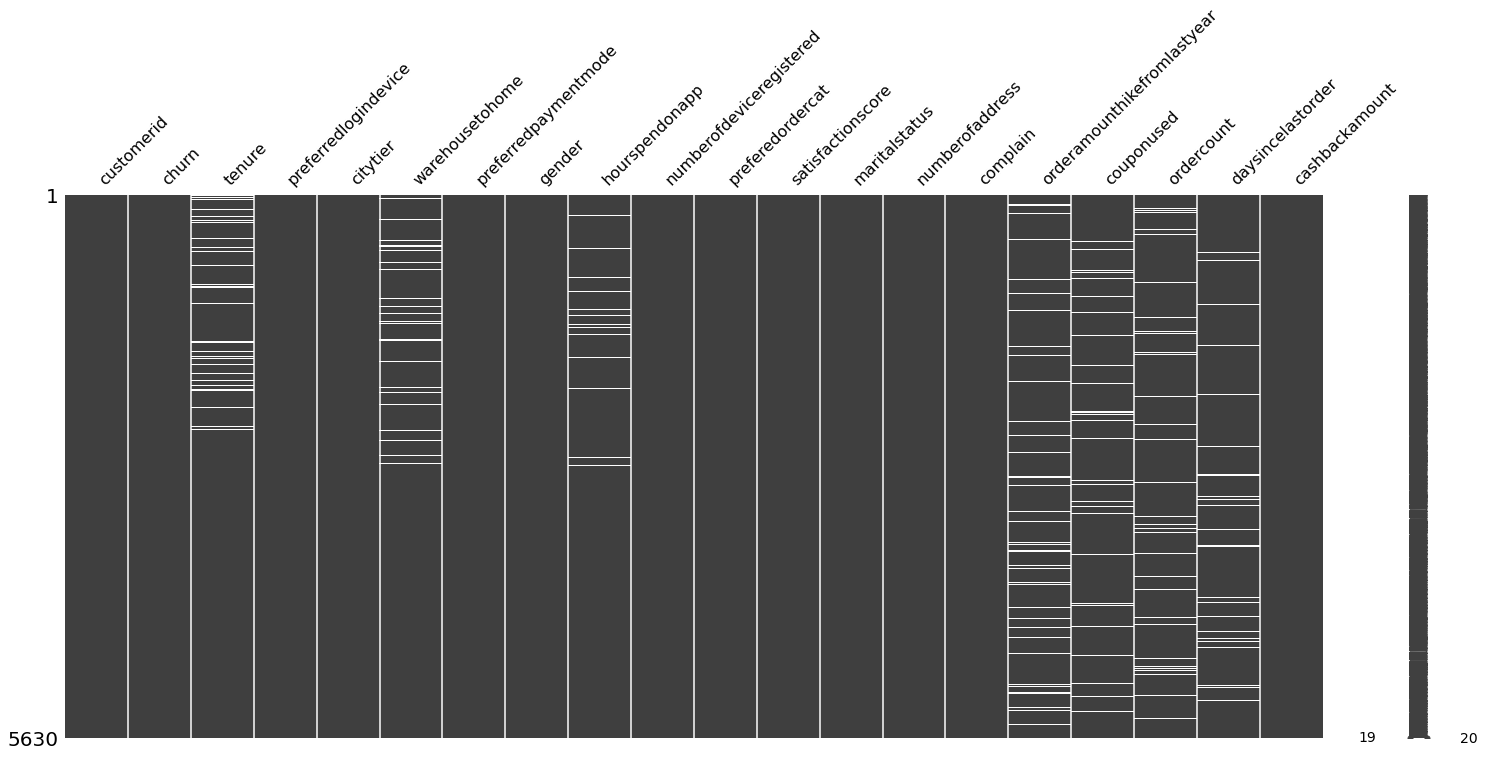

In [ ]:
import missingno as msno
msno.matrix(df)

1. We have 7 columns that have missing values. The amount of missing values is large --> Do not remove --> Replace with other value
2. We need to check these columns are numeric or category.
    - If numeric: replace with mean, median, or 0. If category, replace with mode.
        - Mean: mình sẽ dùng khi cột đó ko có outlier, ko bị skew
        - Median: mình sẽ dùng khi cột có outlier, bị skew  
        - 0: khi cột giá trị của mình có thể tồn tại giá trị 0. Ví dụ: cột đó là cột cân nặng của user, thì ko thể nào có giá trị 0 được
        
&rarr; Mình suggest là chỉ nên thay thế missing value cho numeric columns bằng median hoặc 0 nhen.


In [ ]:
# Check dtypes of columns has missing values:
list_null = df.columns[df.isnull().any()].tolist()
df[list_null].dtypes

tenure                         float64
warehousetohome                float64
hourspendonapp                 float64
orderamounthikefromlastyear    float64
couponused                     float64
ordercount                     float64
daysincelastorder              float64
dtype: object

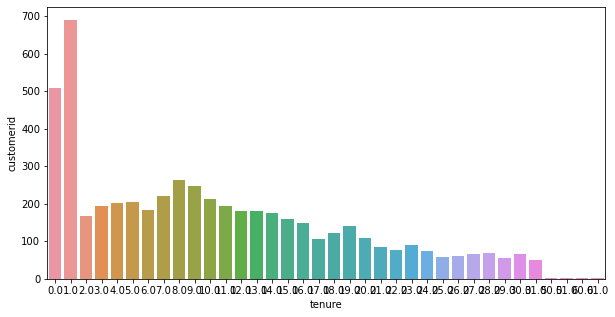

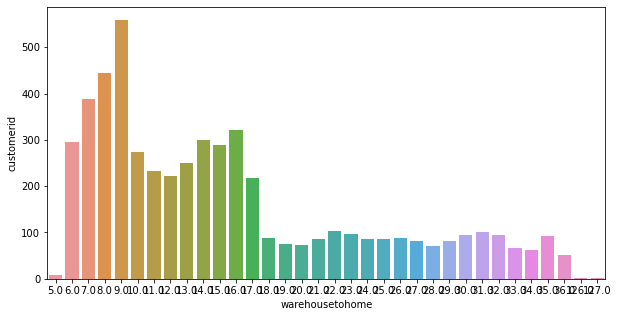

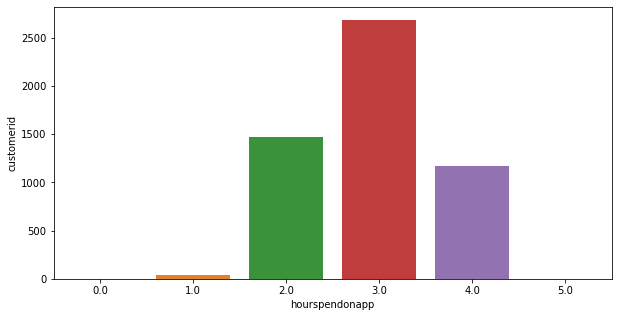

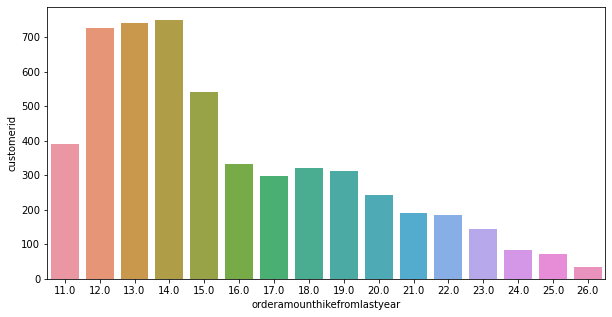

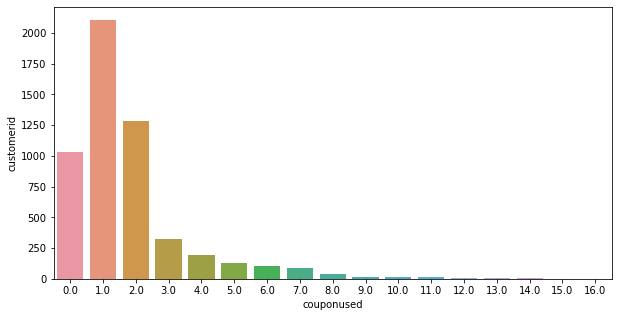

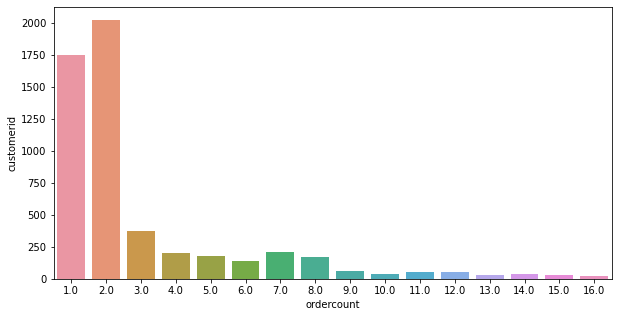

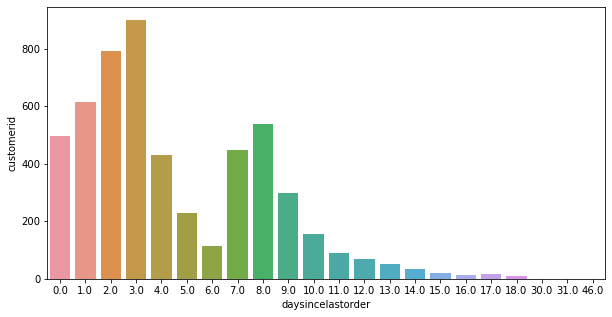

In [ ]:
# Check the distribution to decide we will replace with median or 0:
for i in list_null:
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_df = df.groupby(i)[['customerid']].count().reset_index()
    sns.barplot(data = plot_df,x=plot_df[i],y= plot_df['customerid'],ax=ax)
    plt.show()

After review the distribution, we will replace:
   * The decision was made based on: the meaning of columns and the distribution
        - tenure: median
        - warehousetohome: median
        - hourspendonapp: 0
        - orderamounthikefromlastyear: median
        - couponused: 0
        - ordercount: median
        - daysincelastorder: median

In [ ]:
def replace_func(list_columns):
    for i in list_columns:
        if i in ['tenure','warehousetohome','orderamounthikefromlastyear','ordercount','daysincelastorder']:
            median = df[i].median()
            df[i].fillna(median, inplace=True)
        else:
            df[i].fillna(0, inplace=True)

In [ ]:
replace_func(list_null)

<AxesSubplot:>

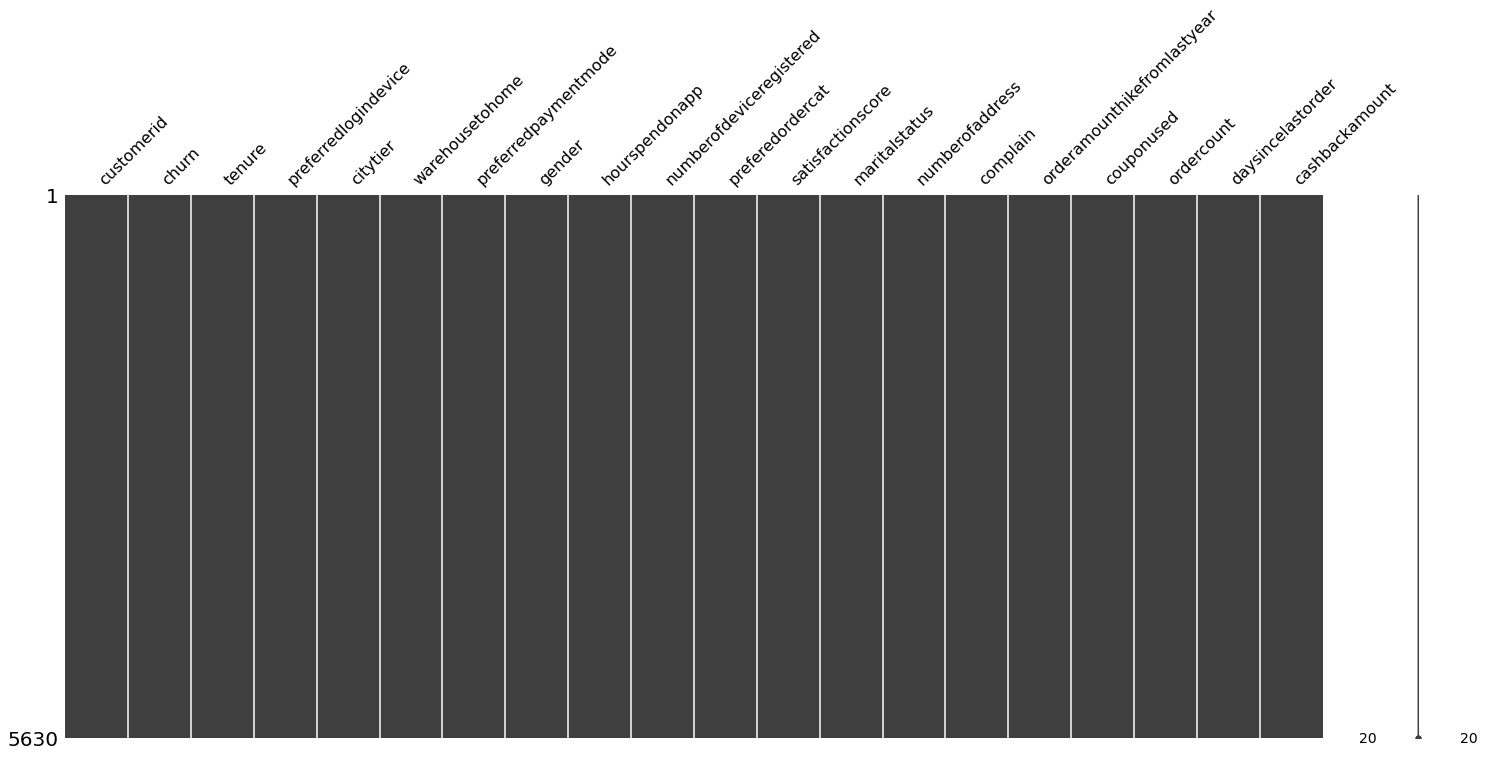

In [ ]:
msno.matrix(df)

#### **1.2 Duplicated Values:**

In [ ]:
df.duplicated().any()

False

&rarr; Data do not have duplicated values

#### **1.3 EDA by applying Decision Tree first:**

In [ ]:
#Encoding:
cate_columns = df.loc[:, df.dtypes == np.object].columns.tolist()
cate_columns

['preferredlogindevice',
 'preferredpaymentmode',
 'gender',
 'preferedordercat',
 'maritalstatus']

In [ ]:
encoded_df = pd.get_dummies(df, columns = cate_columns,drop_first=True)
encoded_df.head()

,customerid,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,...,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Mobile Phone,preferedordercat_Others,maritalstatus_Married,maritalstatus_Single
0,50001,1,4.0,3,6.0,3.0,3,2,9,1,...,0,0,0,0,1,0,0,0,0,1
1,50002,1,9.0,1,8.0,3.0,4,3,7,1,...,0,1,1,0,0,1,0,0,0,1
2,50003,1,9.0,1,30.0,2.0,4,3,6,1,...,0,0,1,0,0,1,0,0,0,1
3,50004,1,0.0,3,15.0,2.0,4,5,8,0,...,0,0,1,0,1,0,0,0,0,1
4,50005,1,0.0,1,12.0,0.0,3,5,3,0,...,0,0,1,0,0,1,0,0,0,1


In [ ]:
#Normalization:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'customerid',inplace=True)
scaled_df.head(4)

,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,orderamounthikefromlastyear,...,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Mobile Phone,preferedordercat_Others,maritalstatus_Married,maritalstatus_Single
0,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.147541,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,0.266667,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.147541,0.0,0.204918,0.4,0.6,0.50,0.238095,1.0,0.200000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.000000,1.0,0.081967,0.4,0.6,1.00,0.333333,0.0,0.800000,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#Applying Decision Tree (without splitting train/test):

In [ ]:
from sklearn.model_selection import train_test_split
x=scaled_df.drop('churn', axis = 1)
y=scaled_df[['churn']]

In [ ]:
from sklearn import tree

clf_des = tree.DecisionTreeClassifier()
clf_des.fit(x,y)

DecisionTreeClassifier()

In [ ]:
#Show Feature Importance:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, clf_des.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

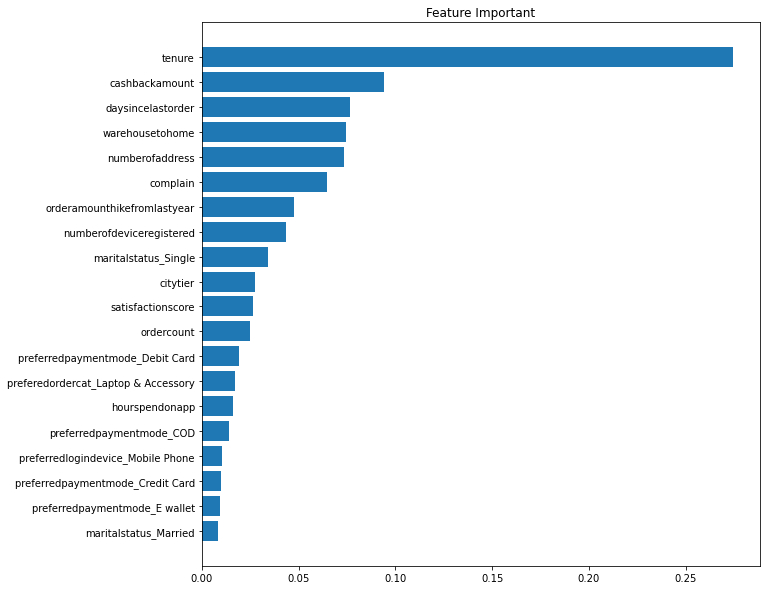

In [ ]:
# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

As Feature Importance show, we can see these features can have high relation with target columns:
* Tenure
* Distance from warehouse to home
* Cashback amount
* Days since Last order
* Number of Address
* Complain
* Order Amount Hike from last year

&rarr; We will analyse and visualize these features for more insights.


#### **1.4 Analyse features from Decision Tree:**


* Tenure
* Distance from warehouse to home
* Cashback amount
* Days since Last order
* Number of Address
* Complain
* Order Amount Hike from last year

In [ ]:
def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of fraud/non-fraud
    transaction on total transaction group by category values
    '''

    # Create 2 dataframes of fraud and non-fraud
    fraud = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_fraud = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = fraud.merge(not_fraud, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'fraud',count+'_y':'not_fraud'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['fraud']/(cate_df['fraud']+cate_df['not_fraud'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df

##### **1.4.1 Tenure**  New users are churned more than old users (tenure = 0 or 1)

<AxesSubplot:xlabel='tenure', ylabel='%'>

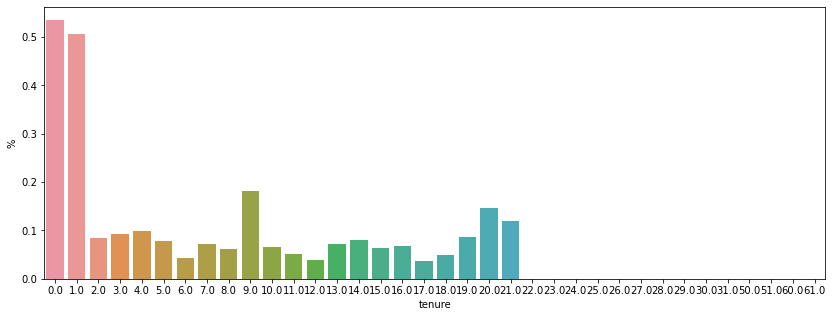

In [ ]:
plot_df = count_percentage(df, 'tenure', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='tenure',y='%', ax=ax)

##### **1.4.1 Warehouse to home**  Not significantly related

<AxesSubplot:xlabel='churn', ylabel='warehousetohome'>

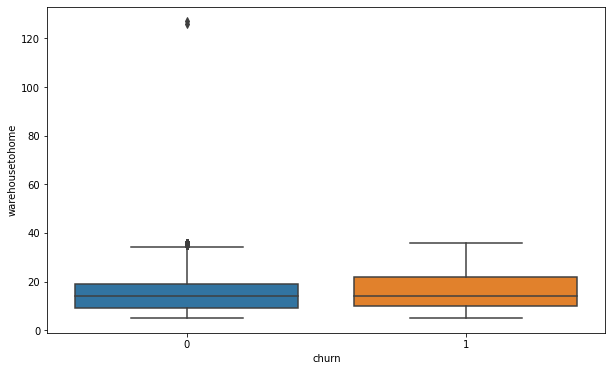

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='churn',y='warehousetohome',ax=ax)

<AxesSubplot:xlabel='churn', ylabel='warehousetohome'>

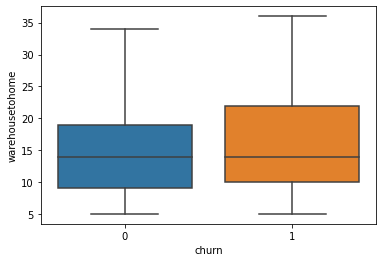

In [ ]:
sns.boxplot(data=df, x='churn',y='warehousetohome', showfliers = False)

In [ ]:
df[df['churn']==1]['warehousetohome'].describe()

count    948.000000
mean      16.856540
std        8.287501
min        5.000000
25%       10.000000
50%       14.000000
75%       22.000000
max       36.000000
Name: warehousetohome, dtype: float64

In [ ]:
df[df['churn']==0]['warehousetohome'].describe()

count    4682.000000
mean       15.305639
std         8.334361
min         5.000000
25%         9.000000
50%        14.000000
75%        19.000000
max       127.000000
Name: warehousetohome, dtype: float64

For both churn & not churn:
* The median, pt25, mean, pt75 is quite the same --> The centralize of data is the same
* For not churn, data has some outliers --> This can be not significant enough to consider it as an insight for not churn

&rarr; There're no strong evidences show that there different between churn and not churn for warehousetohome --> We will exclude this features when apply model for not being bias.

##### **1.4.2 Cashback amount**  Churn users recevied cashback amount less than not churn users.

<AxesSubplot:xlabel='churn', ylabel='cashbackamount'>

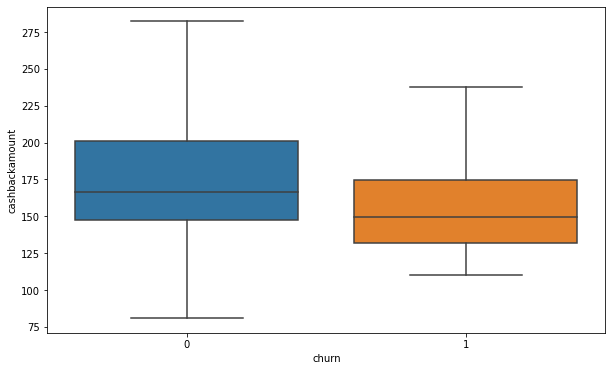

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='churn',y='cashbackamount',ax=ax, showfliers = False)

Churn users recevied cashback amount less than not churn users.

---



##### **1.4.3 Days since last order:** churn users with complain = 1 have higher days since orders than churned users with complain = 0  

<AxesSubplot:xlabel='churn', ylabel='daysincelastorder'>

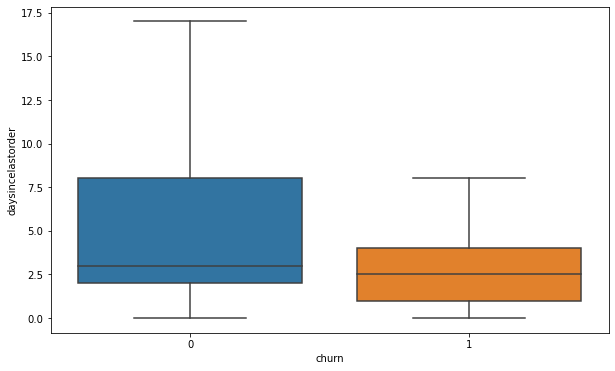

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='churn',y='daysincelastorder',ax=ax, showfliers = False)

From this chart, we see for churned users, they had orders recently (the day since last order less than not churned users) --> This quite strange, we should monitor more features for this insight (satisfaction_score, complain,..)

<AxesSubplot:xlabel='complain', ylabel='daysincelastorder'>

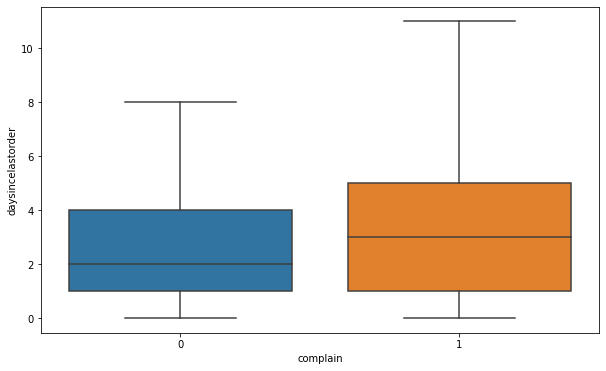

In [ ]:
churn_df = df[df['churn']==1]
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=churn_df, x='complain',y='daysincelastorder',ax=ax, showfliers = False)

For churned users with complain = 1, they had daysincelastorder higher than churn users with compain = 0

##### **1.4.4 Complain** The number of users complain on churn is higher than not churn

<AxesSubplot:xlabel='complain', ylabel='%'>

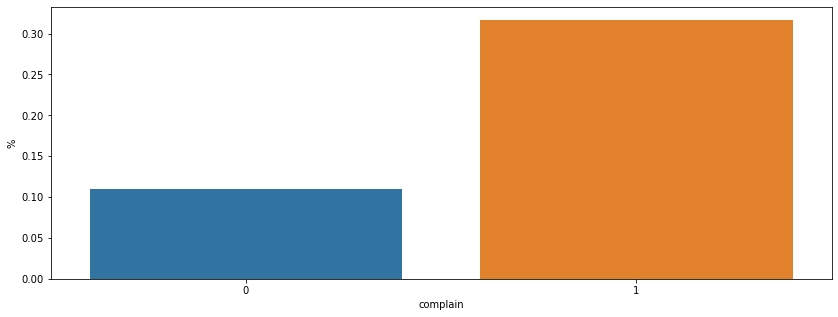

In [ ]:
plot_df = count_percentage(df, 'complain', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='complain',y='%', ax=ax)

##### **1.4.5 Number of Address** There're no relationship

In [ ]:
df['numberofaddress'].nunique()

15

<AxesSubplot:xlabel='numberofaddress', ylabel='%'>

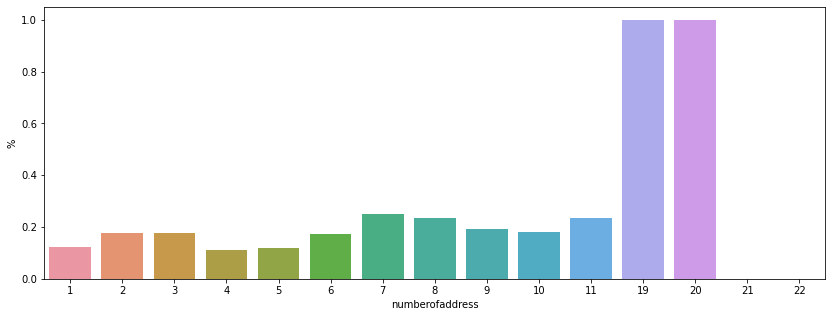

In [ ]:
plot_df = count_percentage(df, 'numberofaddress', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='numberofaddress',y='%', ax=ax)

In [ ]:
df[df['churn']==1].groupby('numberofaddress')[['customerid']].nunique()

,customerid
numberofaddress,
1,45
2,241
3,228
4,65
5,67
6,66
7,64
8,66
9,46


As numberofadress = 19 and 20, we see the % of churn = 100% and the number of churned users = 1 -->This not significant to get the insight

&rarr; We will exclude number of address = 19 and 20 in the data for applying model

##### **1.4.6 Order amount hike from last year**

In [ ]:
df['orderamounthikefromlastyear'].unique()

array([11., 15., 14., 23., 22., 16., 12., 13., 17., 18., 24., 19., 20.,
       21., 25., 26.])

<AxesSubplot:xlabel='orderamounthikefromlastyear', ylabel='%'>

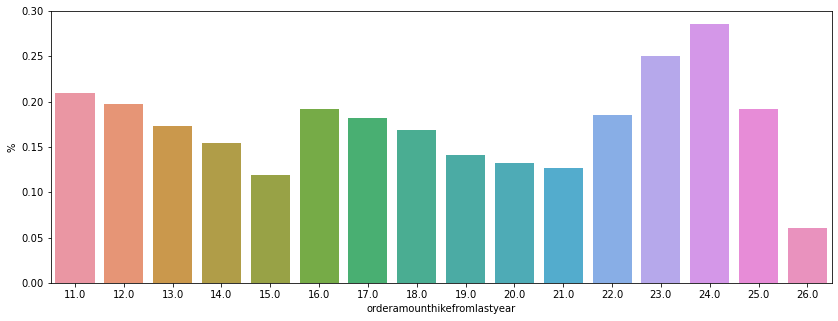

In [ ]:
plot_df = count_percentage(df, 'orderamounthikefromlastyear', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(data=plot_df, x='orderamounthikefromlastyear',y='%', ax=ax)

There're no significant insight from this features

##### **1.4.7 Conclusion & Suggestion**

1. Churned users usually are new users &rarr; Provide more promotion for new users, or increase the new users experience
2. Churned users usually receive less cashback than not churn &rarr; Increase the cashback ratio
3. Churned users complain more &rarr; deep dive what these churned users complain about, and provide the solution

### **2. Feature Transforming:**

In [ ]:
# Remove Warehouse to home and number of address =19,20
df_model = df.drop(columns = 'warehousetohome')
df_model = df_model.drop(df_model[(df_model.numberofaddress == 19)|(df_model.numberofaddress == 20)].index)
df_model.head(1)

,customerid,churn,tenure,preferredlogindevice,citytier,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,50001,1,4.0,Mobile Phone,3,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


In [ ]:
cate_columns = df_model.loc[:, df_model.dtypes == np.object].columns.tolist()
cate_columns

['preferredlogindevice',
 'preferredpaymentmode',
 'gender',
 'preferedordercat',
 'maritalstatus']

In [ ]:
encoded_df = pd.get_dummies(df_model, columns = cate_columns,drop_first=True)
encoded_df.shape

(5628, 30)

In [ ]:
#Scale Feature:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'customerid',inplace=True)

### **3. Model Training & Evaluation:**

#### **3.1 Split train/test set:**

In [ ]:
from sklearn.model_selection import train_test_split
x=scaled_df.drop('churn', axis = 1)
y=scaled_df[['churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#### **3.2 Apply model: Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logis = LogisticRegression(random_state = 0)
clf_logis.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_pred_test = clf_logis.predict(x_test)
y_pred_train = clf_logis.predict(x_train)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
print(balanced_accuracy_train,balanced_accuracy_test)

0.7127869566576288 0.6869139242745931


&rarr; The balanced accuracy of Logistic Regression is 71%
No unerfitting or overfitting

#### **3.2 Apply model: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=15, random_state=0, n_estimators = 100)

clf_rand.fit(x_train, y_train)
y_ranf_pre_train = clf_rand.predict(x_train)
y_ranf_pre_test = clf_rand.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_pre_test)}')

Balance accuracy of train set: 0.9977203647416413
Balance accuracy of test set: 0.8575769639065818


#### **3.3 Enhanced Random Forest model**

**Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30,40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train, y_train)
/
# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test set accuracy:  0.961248654467169


**Re-apply model with new parameters:**

In [ ]:
best_params = grid_search.best_params_
clf_rand_after = RandomForestClassifier(**best_params,random_state=0)

clf_rand_after.fit(x_train, y_train)
y_ranf_aft_train = clf_rand_after.predict(x_train)
y_ranf_aft_test = clf_rand_after.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_aft_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_ranf_aft_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9005175159235669


**&rarr; The balanced accuracy increase to 90% &rarr; Can use this model as final model**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

In [ ]:
precision = precision_score(y_test, y_ranf_aft_test, average='binary')
recall = recall_score(y_test, y_ranf_aft_test, average='binary')

print('Recall:',recall)
print('Precision:', precision)

Recall: 0.8125
Precision: 0.9285714285714286


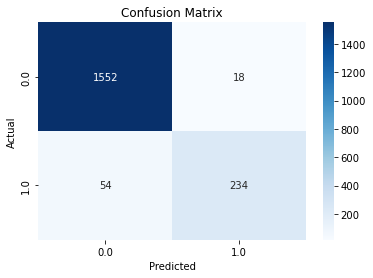

In [ ]:
cm = confusion_matrix(y_test, y_ranf_aft_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**&rarr; Model still can not detect 20% of actual label = 1 data (recall = 81%)**

**&rarr; Next action can take to improve this: Investigate the data that model cannot detect and figure out the reason behind**